<a href="https://colab.research.google.com/github/SiliveriSriharshini/Synthetic-data-generation-and-EDA/blob/main/Option_2_Naukri122024_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Synthetic data**

In [4]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta

# Initialize Faker instance
fake = Faker()

# Parameters for synthetic data generation
locations = [
    "Dallas, TX", "Atlanta, GA", "New York, NY", "Philadelphia, PA", "Washington, DC",
    "San Francisco, CA", "Los Angeles, CA", "Seattle, WA", "Chicago, IL", "San Diego, CA",
    "Miami, FL", "Boston, MA", "Detroit, MI", "Phoenix, AZ", "Houston, TX"
]

job_titles = [
    "RegisteredNurse_ICU", "RegisteredNurse_MedSurg", "RegisteredNurse_Telemetry",
    "RegisteredNurse_Oncology", "RegisteredNurse_Pediatric", "PhysioTherapist",
    "LabTechnician", "RegisteredNurse_CriticalCare", "RegisteredNurse_Cardiology",
    "RegisteredNurse_Surgery"
]

hospital_suffixes = ["Corporate", "NonProfit", "Community", "Veterans", "Govt"]

# Helper functions
def generate_hospital_name(city):
    return f"{city.split(',')[0]} {random.choice(hospital_suffixes)}"

def generate_contract_dates(year):
    start_date = fake.date_between_dates(date_start=datetime(year, 1, 1), date_end=datetime(year, 12, 31))
    end_date = start_date + timedelta(weeks=random.randint(4, 13))
    return start_date, end_date

def generate_hourly_rate(city, job_title, date):
    base_rate = random.randint(30, 60)
    seasonal_multiplier = 1.2 if date.month in [10, 11, 12, 1, 2] else 1.0
    specialization_bonus = 1.1 if "Oncology" in job_title or "Cardiology" in job_title or "Surgery" in job_title else 1.0
    cost_of_living_adjustment = {
        "New York, NY": 1.3, "San Francisco, CA": 1.3, "Boston, MA": 1.2,
        "Seattle, WA": 1.2, "Los Angeles, CA": 1.2, "Miami, FL": 1.1,
    }.get(city, 1.0)
    return round(base_rate * seasonal_multiplier * specialization_bonus * cost_of_living_adjustment, 2)

# Generate synthetic data
num_rows = 250000
data = []
years = [2023, 2024]

for _ in range(num_rows):
    city = random.choice(locations)
    job_title = random.choice(job_titles)
    hospital_name = generate_hospital_name(city)
    year = random.choice(years)
    start_date, end_date = generate_contract_dates(year)
    hourly_rate = generate_hourly_rate(city, job_title, start_date)

    data.append({
        "Job Title": job_title,
        "Location": city,
        "Hospital Name": hospital_name,
        "Contract Start Date": start_date,
        "Contract End Date": end_date,
        "Hourly Pay Rate": hourly_rate
    })

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("nurse_hourly_rates.csv", index=False)

print("Synthetic dataset generated and saved to 'nurse_hourly_rates.csv'")


Synthetic dataset generated and saved to 'nurse_hourly_rates.csv'


# **EDA**

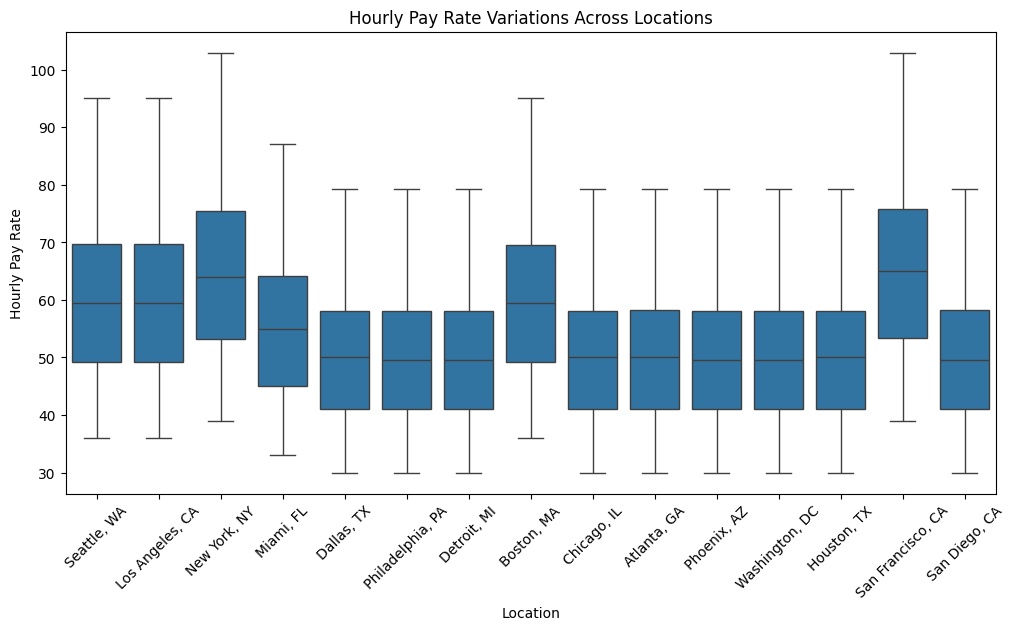

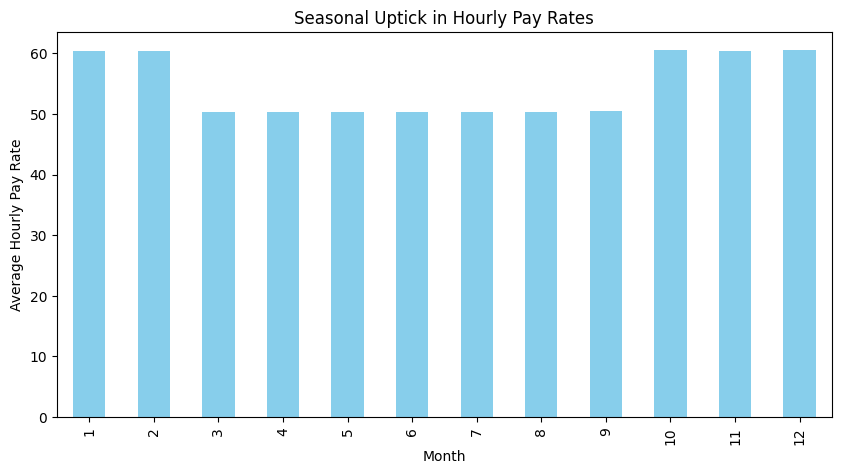

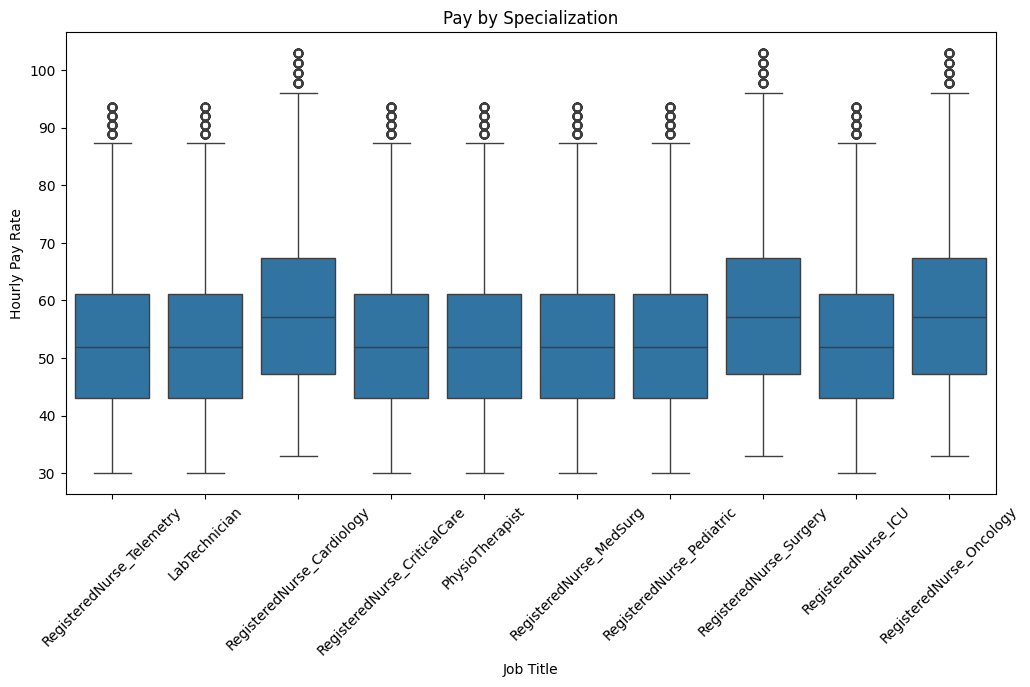

Random Forest Metrics:
Mean Absolute Error: 9.687672913193381
Mean Squared Error: 132.0508103185981
R2 Score: 0.2809328253020189

Linear Regression Metrics:
Mean Absolute Error: 10.032427813092896
Mean Squared Error: 144.5595048201147
R2 Score: 0.2128181988740211


['linear_regression_model.pkl']

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_csv("nurse_hourly_rates.csv")

# EDA
def perform_eda(df):
    # Variations of hourly pay rates across metros
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Location', y='Hourly Pay Rate', data=df)
    plt.xticks(rotation=45)
    plt.title("Hourly Pay Rate Variations Across Locations")
    plt.show()

    # Uptick in pay rates during flu & holiday seasons
    df['Month'] = pd.to_datetime(df['Contract Start Date']).dt.month
    seasonal_data = df.groupby('Month')['Hourly Pay Rate'].mean()
    plt.figure(figsize=(10, 5))
    seasonal_data.plot(kind='bar', color='skyblue')
    plt.title("Seasonal Uptick in Hourly Pay Rates")
    plt.xlabel("Month")
    plt.ylabel("Average Hourly Pay Rate")
    plt.show()

    # Specialization vs. Pay
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Job Title', y='Hourly Pay Rate', data=df)
    plt.xticks(rotation=45)
    plt.title("Pay by Specialization")
    plt.show()

perform_eda(df)

# Data Preprocessing
def preprocess_data(df):
    df['Start Month'] = pd.to_datetime(df['Contract Start Date']).dt.month
    df['Start Year'] = pd.to_datetime(df['Contract Start Date']).dt.year

    # Encoding categorical features
    df = pd.get_dummies(df, columns=['Location', 'Job Title', 'Hospital Name'], drop_first=True)

    # Features and target
    X = df.drop(columns=['Hourly Pay Rate', 'Contract Start Date', 'Contract End Date'])
    y = df['Hourly Pay Rate']

    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = preprocess_data(df)

# Model 1: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Metrics
print("Random Forest Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, rf_preds))
print("Mean Squared Error:", mean_squared_error(y_test, rf_preds))
print("R2 Score:", r2_score(y_test, rf_preds))

# Model 2: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Metrics
print("\nLinear Regression Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, lr_preds))
print("Mean Squared Error:", mean_squared_error(y_test, lr_preds))
print("R2 Score:", r2_score(y_test, lr_preds))

# Bonus: Time Series Forecasting (if needed)
# You can add Prophet or NeuralProphet-based models here.

# Save models (if required for Streamlit)
import joblib
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(lr_model, 'linear_regression_model.pkl')


# **Streamlit app**

In [45]:
with open('streamlit_app.py', 'w') as f:
    f.write('''
import streamlit as st
import pandas as pd
import joblib
from datetime import datetime

# Load pre-trained models
rf_model = joblib.load('random_forest_model.pkl')
lr_model = joblib.load('linear_regression_model.pkl')

# Load data for reference
data = pd.read_csv("nurse_hourly_rates.csv")

# Streamlit App
def main():
    # Display candidate details
    st.markdown(
        f"<div style='background-color: #f9f9f9; color: #000; padding: 1rem;'><h2>Naukri122024</h2></div>",
        unsafe_allow_html=True,
    )

    # App title
    st.title("Nurse Hourly Pay Rate Predictor")
    st.write("This app predicts the hourly pay rate for nurses based on job title, location, hospital, and contract details.")

    # Input Fields
    job_title = st.selectbox("Job Title", data['Job Title'].unique())
    location = st.selectbox("Location", data['Location'].unique())
    hospital_name = st.selectbox("Hospital Name", data['Hospital Name'].unique())
    start_date = st.date_input("Contract Start Date", datetime(2023, 1, 1))
    end_date = st.date_input("Contract End Date", datetime(2023, 4, 1))

    if st.button("Predict Hourly Rate"):
        # Preprocess input
        input_data = {
            "Job Title": job_title,
            "Location": location,
            "Hospital Name": hospital_name,
            "Start Month": start_date.month,
            "Start Year": start_date.year
        }

        # Convert input into DataFrame
        input_df = pd.DataFrame([input_data])

        # Debug: Display the raw input data
        st.write("Raw Input Data:")
        st.write(input_df)

        # Apply one-hot encoding
        input_df = pd.get_dummies(input_df, columns=["Job Title", "Location", "Hospital Name"], drop_first=True)

        # Debug: Display the one-hot encoded input data
        st.write("One-hot Encoded Input Data:")
        st.write(input_df)

        # Align columns with training data
        model_columns = [col for col in rf_model.feature_names_in_]
        for col in model_columns:
            if col not in input_df:
                input_df[col] = 0

        # Ensure the input data matches the model's expected columns
        input_df = input_df[model_columns]

        # Debug: Display the final input data aligned with the model
        st.write("Final Input Data Aligned with Model:")
        st.write(input_df)

        # Predict using both models
        rf_prediction = rf_model.predict(input_df)[0]
        lr_prediction = lr_model.predict(input_df)[0]

        # Debug: Display the predictions
        st.write(f"Random Forest Prediction: {rf_prediction}")
        st.write(f"Linear Regression Prediction: {lr_prediction}")

        # Display Results
        st.success(f"Predicted Hourly Rate (Random Forest): ${rf_prediction:.2f}")
        st.success(f"Predicted Hourly Rate (Linear Regression): ${lr_prediction:.2f}")

if __name__ == "__main__":
    main()


''')



In [26]:
!pip install streamlit


In [46]:
from pyngrok import ngrok
import os

# Kill any processes using the Streamlit default port
os.system("kill -9 $(lsof -t -i:8501)")

# Start the Streamlit app
!streamlit run streamlit_app.py &>/dev/null&

# Set up ngrok tunnel
public_url = ngrok.connect(8501)  # Correctly pass the port number as an integer
print(f"Streamlit app is live at {public_url}")


Streamlit app is live at NgrokTunnel: "https://55d8-35-231-129-223.ngrok-free.app" -> "http://localhost:8501"


# **Time Series Forecasting**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf0ompdx/7n70cjhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf0ompdx/yd42jral.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91966', 'data', 'file=/tmp/tmpaf0ompdx/7n70cjhz.json', 'init=/tmp/tmpaf0ompdx/yd42jral.json', 'output', 'file=/tmp/tmpaf0ompdx/prophet_model6rqn_k7c/prophet_model-20241231093815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:15 - cmdstanpy - INFO - Chain [1] start processing
I

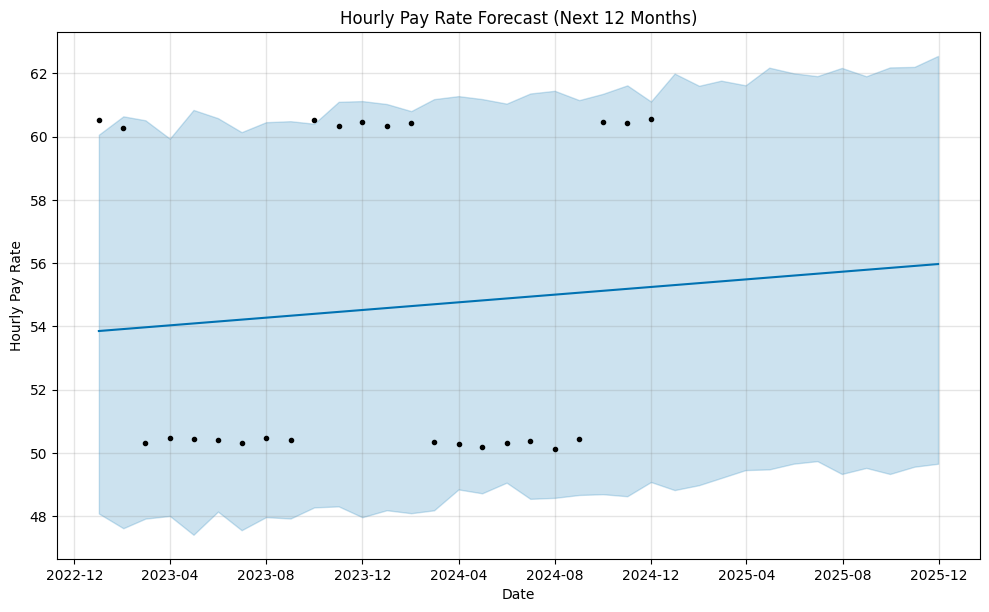

In [25]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("nurse_hourly_rates.csv")

# Extract month and year from the contract start date
df['Contract Start Date'] = pd.to_datetime(df['Contract Start Date'])
df['Month'] = df['Contract Start Date'].dt.to_period('M')

# Convert the 'Month' column from Period to Timestamp (datetime)
df['Month'] = df['Month'].dt.to_timestamp()

# Group by month to get the average hourly pay rate for each month
monthly_data = df.groupby('Month')['Hourly Pay Rate'].mean().reset_index()

# Rename columns for Prophet compatibility
monthly_data = monthly_data.rename(columns={'Month': 'ds', 'Hourly Pay Rate': 'y'})

# Initialize and fit the Prophet model
model = Prophet()

# Fit the model with the historical data
model.fit(monthly_data)

# Make a future dataframe for forecasting (next 12 months)
# Make sure you pass the period and frequency correctly
future = model.make_future_dataframe(periods=12, freq='M')  # Adding future dates

# Forecast
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Hourly Pay Rate Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Hourly Pay Rate")
plt.show()

# Save the forecasted data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("hourly_pay_forecast.csv", index=False)
